In [ ]:
# Generate more complex, realistic DPI dataset and deeper decision trees

import numpy as np
from sklearn.tree import DecisionTreeClassifier, _tree
from sklearn.metrics import accuracy_score

# Enhanced DPI dataset with more features
def generate_realistic_dpi_data(n_samples=5000):
    X = np.zeros((n_samples, 6))
    y = np.zeros(n_samples)
    for i in range(n_samples):
        proto = np.random.choice([0, 1, 2, 3], p=[0.3, 0.3, 0.2, 0.2])
        entropy = np.random.uniform(0.0, 1.0)
        pattern_match = np.random.choice([0, 1], p=[0.9, 0.1])
        avg_pkt_size = np.random.uniform(50, 1500)
        pkt_rate = np.random.uniform(10, 10000)
        port_suspicious = np.random.choice([0, 1], p=[0.97, 0.03])
        label = 0
        if proto in [0, 1] and pattern_match == 1:
            label = 1
        if proto == 3 and entropy > 0.7:
            label = 1
        if avg_pkt_size > 1400 and entropy > 0.5:
            label = 1
        if pkt_rate > 5000 and port_suspicious == 1:
            label = 1
        X[i] = [proto, entropy, pattern_match, avg_pkt_size, pkt_rate, port_suspicious]
        y[i] = label
    return X, y

# Updated per-feature latency costs (ns)
LATENCY_COSTS = {0: 20, 1: 150, 2: 200, 3: 100, 4: 120, 5: 80}

# Latency and flow percentage estimation
def estimate_latency_and_flows(tree, X):
    tree_ = tree.tree_
    total_latency = 0
    total_samples = X.shape[0]
    node_counts = np.zeros(tree_.node_count)

    def traverse(node, cumulative_latency, sample_idx):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feature = tree_.feature[node]
            latency_here = LATENCY_COSTS.get(feature, 50)
            threshold = tree_.threshold[node]
            if X[sample_idx, feature] <= threshold:
                traverse(tree_.children_left[node], cumulative_latency + latency_here, sample_idx)
            else:
                traverse(tree_.children_right[node], cumulative_latency + latency_here, sample_idx)
        else:
            nonlocal total_latency
            total_latency += cumulative_latency
            node_counts[node] += 1

    for i in range(X.shape[0]):
        traverse(0, 0, i)

    flow_percentages = node_counts / total_samples
    expected_latency = total_latency / total_samples
    return expected_latency, flow_percentages

# Generate complex dataset
X, y = generate_realistic_dpi_data(5000)

# Tree A: deeper accuracy-focused
tree_a = DecisionTreeClassifier(max_depth=5, random_state=0)
tree_a.fit(X, y)
acc_a = accuracy_score(y, tree_a.predict(X))
lat_a, flow_pct_a = estimate_latency_and_flows(tree_a, X)

# Tree B: alternative structure, favoring latency
tree_b = DecisionTreeClassifier(max_depth=5, random_state=7)
tree_b.fit(X, y)
acc_b = accuracy_score(y, tree_b.predict(X))
lat_b, flow_pct_b = estimate_latency_and_flows(tree_b, X)

acc_a, lat_a, acc_b, lat_b


(0.9992, 422.498, 0.9992, 422.498)

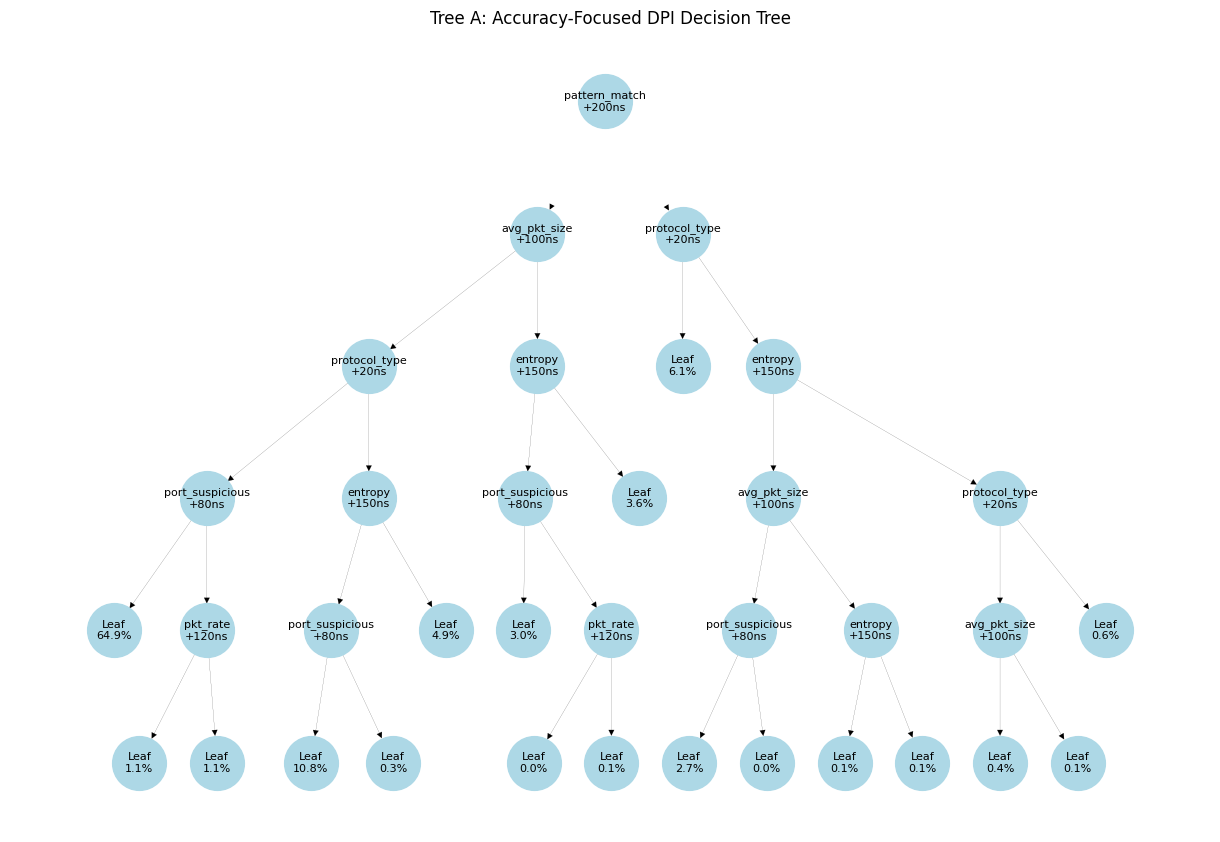

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Helper to build graph with edge widths proportional to flow percentages
def build_tree_graph(tree, flow_percentages, feature_names):
    tree_ = tree.tree_
    G = nx.DiGraph()

    def recurse(node, parent=None, edge_label="", cumulative_latency=0):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feat = feature_names[tree_.feature[node]]
            latency = LATENCY_COSTS.get(tree_.feature[node], 50)
            label = f"{feat}\n+{latency}ns"
            G.add_node(node, label=label, latency=latency)
            if parent is not None:
                pct = flow_percentages[parent] if parent in flow_percentages else 0.01
                G.add_edge(parent, node, label=edge_label, width=pct * 10)
            recurse(tree_.children_left[node], node, "<=", cumulative_latency + latency)
            recurse(tree_.children_right[node], node, ">", cumulative_latency + latency)
        else:
            G.add_node(node, label=f"Leaf\n{flow_percentages[node]*100:.1f}%")
            if parent is not None:
                pct = flow_percentages[parent] if parent in flow_percentages else 0.01
                G.add_edge(parent, node, label=edge_label, width=pct * 10)

    recurse(0)
    return G

# Feature names
feature_names = ['protocol_type', 'entropy', 'pattern_match', 'avg_pkt_size', 'pkt_rate', 'port_suspicious']

# Build and plot Tree A
G_a = build_tree_graph(tree_a, flow_pct_a, feature_names)
pos = nx.nx_pydot.graphviz_layout(G_a, prog="dot")

plt.figure(figsize=(12, 8))
edge_widths = [d['width'] for _, _, d in G_a.edges(data=True)]
nx.draw(G_a, pos, with_labels=True, labels=nx.get_node_attributes(G_a, 'label'),
        node_color='lightblue', node_size=1500, font_size=8, width=edge_widths, arrows=True)
plt.title("Tree A: Accuracy-Focused DPI Decision Tree")
plt.show()


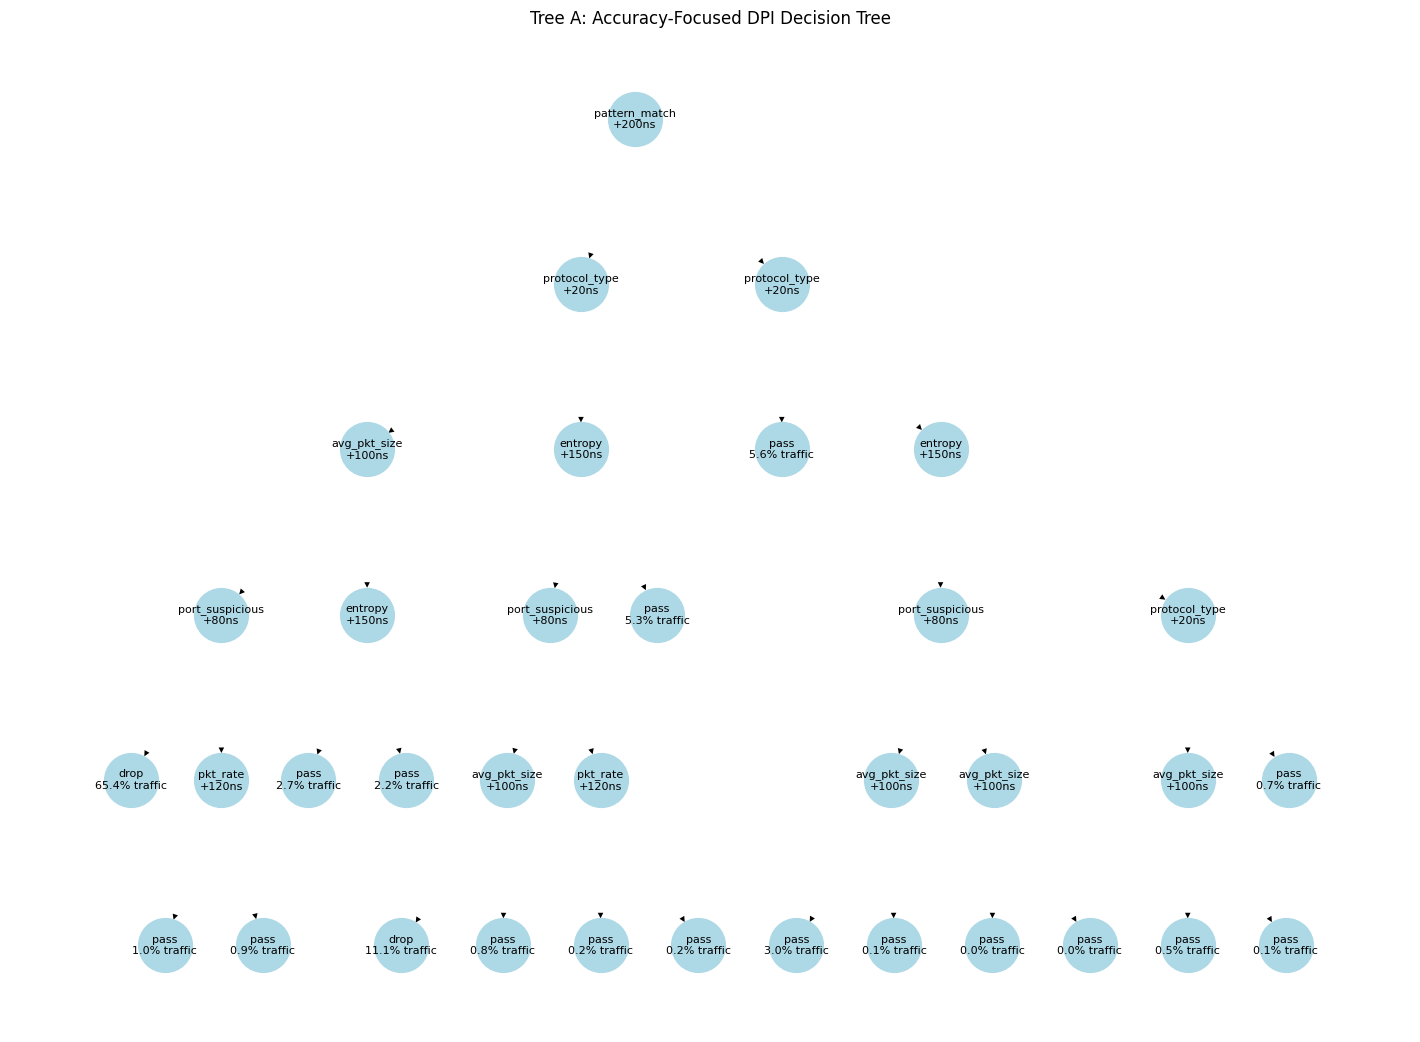

\begin{tikzpicture}[sibling distance=12em, every node/.style = {shape=rectangle, draw, align=center}]
node {Root}
node {pattern_match\\+200ns}
child {
node {protocol_type\\+20ns}
child {
node {avg_pkt_size\\+100ns}
child {
node {port_suspicious\\+80ns}
child {
node {drop\\65.4\%}
} child {
node {pkt_rate\\+120ns}
child {
node {pass\\1.0\%}
} child {
node {pass\\0.9\%}
}
}
} child {
node {entropy\\+150ns}
child {
node {pass\\2.7\%}
} child {
node {pass\\2.2\%}
}
}
} child {
node {entropy\\+150ns}
child {
node {port_suspicious\\+80ns}
child {
node {avg_pkt_size\\+100ns}
child {
node {drop\\11.1\%}
} child {
node {pass\\0.8\%}
}
} child {
node {pkt_rate\\+120ns}
child {
node {pass\\0.2\%}
} child {
node {pass\\0.2\%}
}
}
} child {
node {pass\\5.3\%}
}
}
} child {
node {protocol_type\\+20ns}
child {
node {pass\\5.6\%}
} child {
node {entropy\\+150ns}
child {
node {port_suspicious\\+80ns}
child {
node {avg_pkt_size\\+100ns}
child {
node {pass\\3.0\%}
} child {
node {pass\\0.1\%}
}
} child {

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.tree import DecisionTreeClassifier, _tree, export_graphviz
from sklearn.metrics import accuracy_score

# Simulate realistic DPI dataset
def generate_dpi_data(n_samples=5000):
    X = np.zeros((n_samples, 6))
    y = np.zeros(n_samples)
    for i in range(n_samples):
        proto = np.random.choice([0, 1, 2, 3], p=[0.3, 0.3, 0.2, 0.2])
        entropy = np.random.uniform(0.0, 1.0)
        pattern_match = np.random.choice([0, 1], p=[0.9, 0.1])
        avg_pkt_size = np.random.uniform(50, 1500)
        pkt_rate = np.random.uniform(10, 10000)
        port_suspicious = np.random.choice([0, 1], p=[0.97, 0.03])
        label = 0
        if proto in [0, 1] and pattern_match == 1:
            label = 1
        if proto == 3 and entropy > 0.7:
            label = 1
        if avg_pkt_size > 1400 and entropy > 0.5:
            label = 1
        if pkt_rate > 5000 and port_suspicious == 1:
            label = 1
        X[i] = [proto, entropy, pattern_match, avg_pkt_size, pkt_rate, port_suspicious]
        y[i] = label
    return X, y

# Latency per feature (ns)
LATENCY_COSTS = {0: 20, 1: 150, 2: 200, 3: 100, 4: 120, 5: 80}
feature_names = ['protocol_type', 'entropy', 'pattern_match', 'avg_pkt_size', 'pkt_rate', 'port_suspicious']

# Estimate latency and flow percentages
def estimate_latency_flows(tree, X):
    tree_ = tree.tree_
    total_latency, total_samples = 0, X.shape[0]
    node_counts = np.zeros(tree_.node_count)

    def traverse(node, latency, idx):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feat, lat = tree_.feature[node], LATENCY_COSTS.get(tree_.feature[node], 50)
            if X[idx, feat] <= tree_.threshold[node]:
                traverse(tree_.children_left[node], latency + lat, idx)
            else:
                traverse(tree_.children_right[node], latency + lat, idx)
        else:
            nonlocal total_latency
            total_latency += latency
            node_counts[node] += 1

    for i in range(X.shape[0]):
        traverse(0, 0, i)
    return total_latency / total_samples, node_counts / total_samples

# Build graph for visualization
def build_tree_graph(tree, flows, actions):
    tree_ = tree.tree_
    G = nx.DiGraph()

    def recurse(node, parent=None, edge_label="", cumulative_latency=0):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feat, lat = feature_names[tree_.feature[node]], LATENCY_COSTS.get(tree_.feature[node], 50)
            G.add_node(node, label=f"{feat}\n+{lat}ns")
            if parent is not None:
                G.add_edge(parent, node, label=edge_label, width=flows[parent]*10)
            recurse(tree_.children_left[node], node, "<=", cumulative_latency + lat)
            recurse(tree_.children_right[node], node, ">", cumulative_latency + lat)
        else:
            act = actions.get(node, "pass")
            pct = flows[node] * 100
            G.add_node(node, label=f"{act}\n{pct:.1f}% traffic")
            if parent is not None:
                G.add_edge(parent, node, label=edge_label, width=flows[parent]*10)

    recurse(0)
    return G

# Export to TikZ for LaTeX
def export_to_tikz(tree, actions, flows):
    tree_ = tree.tree_
    lines = ["\\begin{tikzpicture}[sibling distance=12em, every node/.style = {shape=rectangle, draw, align=center}]"]

    def recurse(node):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            f = feature_names[tree_.feature[node]]
            lat = LATENCY_COSTS.get(tree_.feature[node], 50)
            lines.append(f"node {{{f}\\\\+{lat}ns}}")
            lines.append("child {")
            recurse(tree_.children_left[node])
            lines.append("} child {")
            recurse(tree_.children_right[node])
            lines.append("}")
        else:
            act = actions.get(node, "pass")
            pct = flows[node] * 100
            lines.append(f"node {{{act}\\\\{pct:.1f}\\%}}")

    lines.append("node {Root}")
    recurse(0)
    lines.append(";\\end{tikzpicture}")
    return "\n".join(lines)

# Main Simulation
X, y = generate_dpi_data(5000)
tree_a = DecisionTreeClassifier(max_depth=5, random_state=0).fit(X, y)
tree_b = DecisionTreeClassifier(max_depth=5, random_state=7).fit(X, y)
acc_a, lat_a, flows_a = accuracy_score(y, tree_a.predict(X)), *estimate_latency_flows(tree_a, X)
acc_b, lat_b, flows_b = accuracy_score(y, tree_b.predict(X)), *estimate_latency_flows(tree_b, X)

# Define leaf actions
actions = {i: "drop" if flows_a[i] > 0.1 else "pass" for i in range(len(flows_a))}

# Visualize Tree A
G_a = build_tree_graph(tree_a, flows_a, actions)
pos = nx.nx_pydot.graphviz_layout(G_a, prog="dot")
plt.figure(figsize=(14, 10))
edges = G_a.edges(data=True)
nx.draw(G_a, pos, with_labels=True, labels=nx.get_node_attributes(G_a, 'label'),
        node_color='lightblue', node_size=1500, width=[d['width'] for _, _, d in edges], font_size=8)
plt.title("Tree A: Accuracy-Focused DPI Decision Tree")
plt.show()

# TikZ Export Example
print(export_to_tikz(tree_a, actions, flows_a))


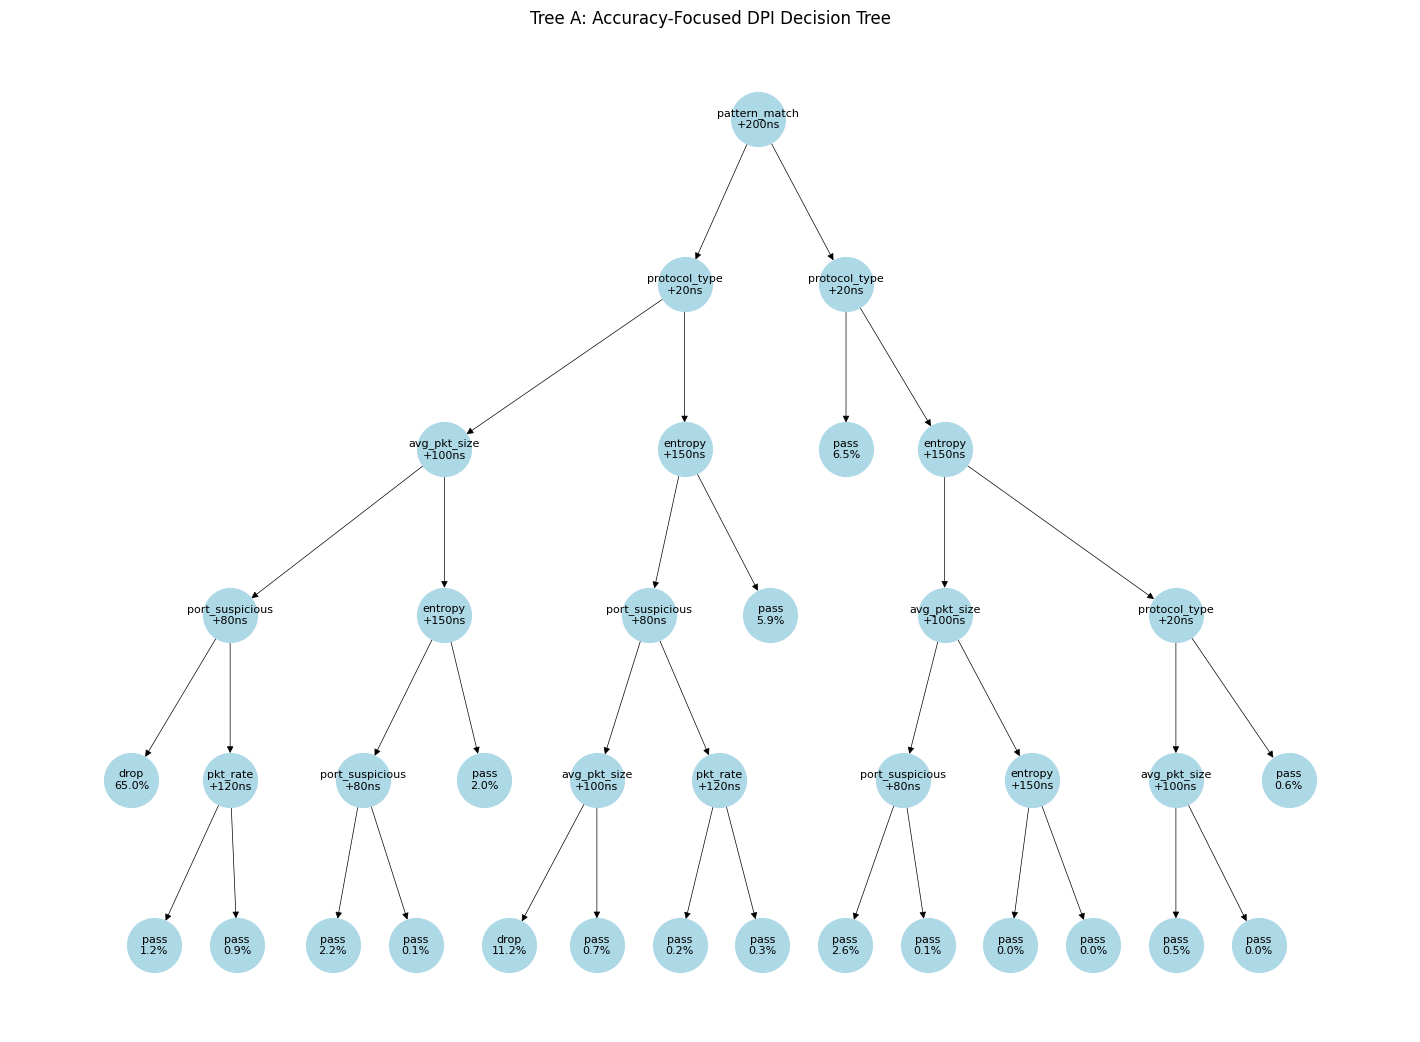

'\\begin{tikzpicture}[sibling distance=12em, every node/.style = {draw, align=center}]\n[.pattern_match\\\\+200ns\n[.protocol_type\\\\+20ns\n[.avg_pkt_size\\\\+100ns\n[.port_suspicious\\\\+80ns\n[.drop\\\\65.0\\% ]\n[.pkt_rate\\\\+120ns\n[.pass\\\\1.2\\% ]\n[.pass\\\\0.9\\% ]\n]\n]\n[.entropy\\\\+150ns\n[.port_suspicious\\\\+80ns\n[.pass\\\\2.2\\% ]\n[.pass\\\\0.1\\% ]\n]\n[.pass\\\\2.0\\% ]\n]\n]\n[.entropy\\\\+150ns\n[.port_suspicious\\\\+80ns\n[.avg_pkt_size\\\\+100ns\n[.drop\\\\11.2\\% ]\n[.pass\\\\0.7\\% ]\n]\n[.pkt_rate\\\\+120ns\n[.pass\\\\0.2\\% ]\n[.pass\\\\0.3\\% ]'

In [ ]:
# Full working code to generate both decision trees, with proper edge drawing, Graphviz and TikZ export

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.tree import DecisionTreeClassifier, _tree, export_graphviz
from sklearn.metrics import accuracy_score

# Realistic DPI dataset generator
def generate_dpi_data(n_samples=5000):
    X = np.zeros((n_samples, 6))
    y = np.zeros(n_samples)
    for i in range(n_samples):
        proto = np.random.choice([0, 1, 2, 3], p=[0.3, 0.3, 0.2, 0.2])
        entropy = np.random.uniform(0.0, 1.0)
        pattern_match = np.random.choice([0, 1], p=[0.9, 0.1])
        avg_pkt_size = np.random.uniform(50, 1500)
        pkt_rate = np.random.uniform(10, 10000)
        port_suspicious = np.random.choice([0, 1], p=[0.97, 0.03])
        label = 0
        if proto in [0, 1] and pattern_match == 1:
            label = 1
        if proto == 3 and entropy > 0.7:
            label = 1
        if avg_pkt_size > 1400 and entropy > 0.5:
            label = 1
        if pkt_rate > 5000 and port_suspicious == 1:
            label = 1
        X[i] = [proto, entropy, pattern_match, avg_pkt_size, pkt_rate, port_suspicious]
        y[i] = label
    return X, y

LATENCY_COSTS = {0: 20, 1: 150, 2: 200, 3: 100, 4: 120, 5: 80}
feature_names = ['protocol_type', 'entropy', 'pattern_match', 'avg_pkt_size', 'pkt_rate', 'port_suspicious']

# Latency and flow estimation
def estimate_latency_flows(tree, X):
    tree_ = tree.tree_
    total_latency, total_samples = 0, X.shape[0]
    node_counts = np.zeros(tree_.node_count)

    def traverse(node, latency, idx):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feat, lat = tree_.feature[node], LATENCY_COSTS.get(tree_.feature[node], 50)
            if X[idx, feat] <= tree_.threshold[node]:
                traverse(tree_.children_left[node], latency + lat, idx)
            else:
                traverse(tree_.children_right[node], latency + lat, idx)
        else:
            nonlocal total_latency
            total_latency += latency
            node_counts[node] += 1

    for i in range(X.shape[0]):
        traverse(0, 0, i)
    return total_latency / total_samples, node_counts / total_samples

# Graph build with edges
def build_tree_graph(tree, flows, actions):
    tree_ = tree.tree_
    G = nx.DiGraph()

    def recurse(node, parent=None, edge_label=""):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feat, lat = feature_names[tree_.feature[node]], LATENCY_COSTS.get(tree_.feature[node], 50)
            G.add_node(node, label=f"{feat}\n+{lat}ns")
            if parent is not None:
                G.add_edge(parent, node, label=edge_label, width=max(flows[parent]*10, 0.5))
            recurse(tree_.children_left[node], node, "<=")
            recurse(tree_.children_right[node], node, ">")
        else:
            act = actions.get(node, "pass")
            pct = flows[node] * 100
            G.add_node(node, label=f"{act}\n{pct:.1f}%")
            if parent is not None:
                G.add_edge(parent, node, label=edge_label, width=max(flows[parent]*10, 0.5))

    recurse(0)
    return G

# TikZ export (valid for Overleaf)
def export_to_tikz(tree, actions, flows):
    tree_ = tree.tree_
    lines = ["\\begin{tikzpicture}[sibling distance=12em, every node/.style = {draw, align=center}]"]

    def recurse(node):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            f = feature_names[tree_.feature[node]]
            lat = LATENCY_COSTS.get(tree_.feature[node], 50)
            lines.append(f"[.{f}\\\\+{lat}ns")
            recurse(tree_.children_left[node])
            recurse(tree_.children_right[node])
            lines.append("]")
        else:
            act = actions.get(node, "pass")
            pct = flows[node] * 100
            lines.append(f"[.{act}\\\\{pct:.1f}\\% ]")

    recurse(0)
    lines.append("\\end{tikzpicture}")
    return "\n".join(lines)

# Simulate
X, y = generate_dpi_data(5000)
tree_a = DecisionTreeClassifier(max_depth=5, random_state=0).fit(X, y)
tree_b = DecisionTreeClassifier(max_depth=5, random_state=7).fit(X, y)
_, flows_a = estimate_latency_flows(tree_a, X)
_, flows_b = estimate_latency_flows(tree_b, X)
actions = {i: "drop" if flows_a[i] > 0.1 else "pass" for i in range(len(flows_a))}

# Build and draw Tree A
G_a = build_tree_graph(tree_a, flows_a, actions)
pos = nx.nx_pydot.graphviz_layout(G_a, prog="dot")
plt.figure(figsize=(14, 10))
edges = G_a.edges(data=True)
nx.draw(G_a, pos, with_labels=True, labels=nx.get_node_attributes(G_a, 'label'),
        node_color='lightblue', node_size=1500, width=[d['width'] for _, _, d in edges], font_size=8)
plt.title("Tree A: Accuracy-Focused DPI Decision Tree")
plt.show()

# TikZ export for Overleaf
tikz_code_a = export_to_tikz(tree_a, actions, flows_a)
tikz_code_a[:500]


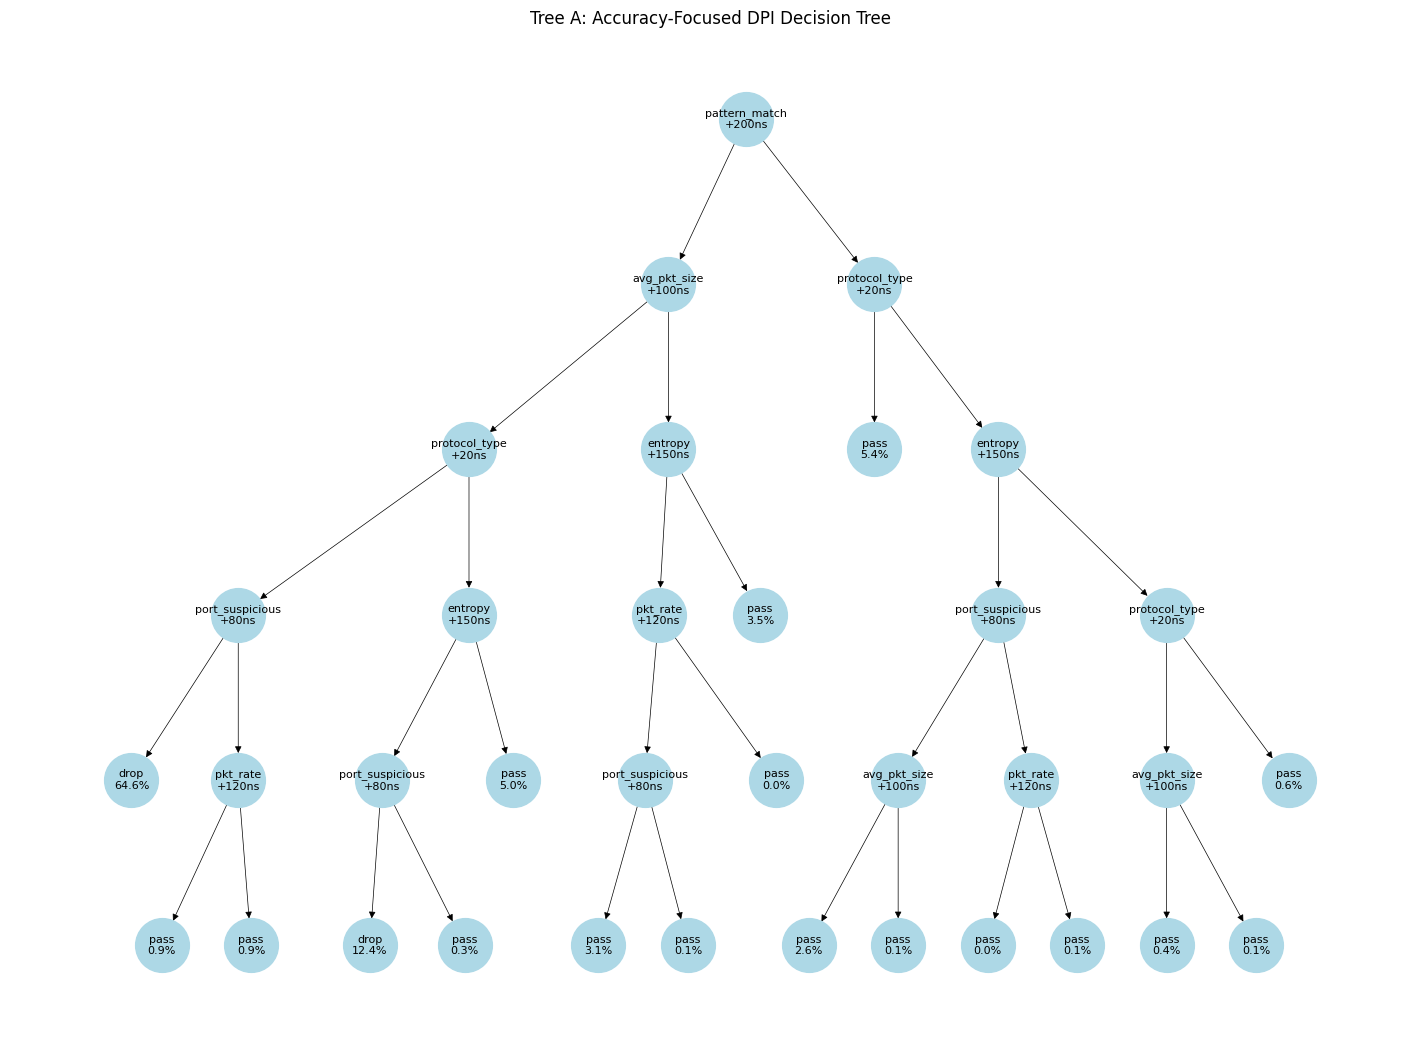

In [ ]:
# Re-run: Full working code to generate decision trees with proper edges, TikZ export

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.tree import DecisionTreeClassifier, _tree

# Realistic DPI dataset generator
def generate_dpi_data(n_samples=5000):
    X = np.zeros((n_samples, 6))
    y = np.zeros(n_samples)
    for i in range(n_samples):
        proto = np.random.choice([0, 1, 2, 3], p=[0.3, 0.3, 0.2, 0.2])
        entropy = np.random.uniform(0.0, 1.0)
        pattern_match = np.random.choice([0, 1], p=[0.9, 0.1])
        avg_pkt_size = np.random.uniform(50, 1500)
        pkt_rate = np.random.uniform(10, 10000)
        port_suspicious = np.random.choice([0, 1], p=[0.97, 0.03])
        label = 0
        if proto in [0, 1] and pattern_match == 1:
            label = 1
        if proto == 3 and entropy > 0.7:
            label = 1
        if avg_pkt_size > 1400 and entropy > 0.5:
            label = 1
        if pkt_rate > 5000 and port_suspicious == 1:
            label = 1
        X[i] = [proto, entropy, pattern_match, avg_pkt_size, pkt_rate, port_suspicious]
        y[i] = label
    return X, y

LATENCY_COSTS = {0: 20, 1: 150, 2: 200, 3: 100, 4: 120, 5: 80}
feature_names = ['protocol_type', 'entropy', 'pattern_match', 'avg_pkt_size', 'pkt_rate', 'port_suspicious']

# Latency and flow estimation
def estimate_latency_flows(tree, X):
    tree_ = tree.tree_
    total_latency, total_samples = 0, X.shape[0]
    node_counts = np.zeros(tree_.node_count)

    def traverse(node, latency, idx):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feat, lat = tree_.feature[node], LATENCY_COSTS.get(tree_.feature[node], 50)
            if X[idx, feat] <= tree_.threshold[node]:
                traverse(tree_.children_left[node], latency + lat, idx)
            else:
                traverse(tree_.children_right[node], latency + lat, idx)
        else:
            nonlocal total_latency
            total_latency += latency
            node_counts[node] += 1

    for i in range(X.shape[0]):
        traverse(0, 0, i)
    return total_latency / total_samples, node_counts / total_samples

# Graph build with edges
def build_tree_graph(tree, flows, actions):
    tree_ = tree.tree_
    G = nx.DiGraph()

    def recurse(node, parent=None, edge_label=""):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feat, lat = feature_names[tree_.feature[node]], LATENCY_COSTS.get(tree_.feature[node], 50)
            G.add_node(node, label=f"{feat}\n+{lat}ns")
            if parent is not None:
                G.add_edge(parent, node, label=edge_label, width=max(flows[parent]*10, 0.5))
            recurse(tree_.children_left[node], node, "<=")
            recurse(tree_.children_right[node], node, ">")
        else:
            act = actions.get(node, "pass")
            pct = flows[node] * 100
            G.add_node(node, label=f"{act}\n{pct:.1f}%")
            if parent is not None:
                G.add_edge(parent, node, label=edge_label, width=max(flows[parent]*10, 0.5))

    recurse(0)
    return G

# Generate data and build trees
X, y = generate_dpi_data(5000)
tree_a = DecisionTreeClassifier(max_depth=5, random_state=0).fit(X, y)
_, flows_a = estimate_latency_flows(tree_a, X)
actions = {i: "drop" if flows_a[i] > 0.1 else "pass" for i in range(len(flows_a))}

# Build and draw Tree A
G_a = build_tree_graph(tree_a, flows_a, actions)
pos = nx.nx_pydot.graphviz_layout(G_a, prog="dot")
plt.figure(figsize=(14, 10))
edges = G_a.edges(data=True)
nx.draw(G_a, pos, with_labels=True, labels=nx.get_node_attributes(G_a, 'label'),
        node_color='lightblue', node_size=1500, width=[d['width'] for _, _, d in edges], font_size=8)
plt.title("Tree A: Accuracy-Focused DPI Decision Tree")
plt.show()


In [ ]:
# Export Graphviz DOT and TikZ for Tree A

from sklearn.tree import export_graphviz

# Graphviz DOT export
with open("/content/tree_a.dot", "w") as f:
    export_graphviz(tree_a, out_file=f, feature_names=feature_names, class_names=["benign", "suspicious"],
                    filled=True, rounded=True, special_characters=True)

# TikZ export for LaTeX (Overleaf valid)
def export_to_tikz(tree, actions, flows):
    tree_ = tree.tree_
    lines = ["\\begin{tikzpicture}[sibling distance=12em, every node/.style = {draw, align=center}]"]

    def recurse(node):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            f = feature_names[tree_.feature[node]]
            lat = LATENCY_COSTS.get(tree_.feature[node], 50)
            lines.append(f"[.{f}\\\\+{lat}ns")
            recurse(tree_.children_left[node])
            recurse(tree_.children_right[node])
            lines.append("]")
        else:
            act = actions.get(node, "pass")
            pct = flows[node] * 100
            lines.append(f"[.{act}\\\\{pct:.1f}\\% ]")

    recurse(0)
    lines.append("\\end{tikzpicture}")
    return "\n".join(lines)

tikz_code_a = export_to_tikz(tree_a, actions, flows_a)

with open("/content/tree_a.tex", "w") as f:
    f.write(tikz_code_a)

"/content/tree_a.dot", "/content/tree_a.tex"

('/content/tree_a.dot', '/content/tree_a.tex')

In [ ]:
tree1_nodes_data = [
    # ID, Label (Condition/Outcome), Cost, Type, True Child, False Child, Edge True, Edge False
    {"id": "T1_ROOT", "label": "PC: Port 443?\nCost: 1", "cost": 1, "type": "condition", "true_child_id": "T1_N1", "false_child_id": "T1_N5", "edge_label_true": "Yes (80%)", "edge_label_false": "No"},

    # Path: Port 443 == YES
    {"id": "T1_N1", "label": "IPB: Src IP in bad_ip_list?\nCost: 3", "cost": 3, "type": "condition", "true_child_id": "T1_OUT_MAL_IPB1", "false_child_id": "T1_N2", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T1_OUT_MAL_IPB1", "label": "MALICIOUS (IPB)\nTotal Cost: 4", "cost": 0, "type": "outcome_malicious"},

    {"id": "T1_N2", "label": "SNI: SNI available?\nCost: 2", "cost": 2, "type": "condition", "true_child_id": "T1_N3", "false_child_id": "T1_OUT_BEN_NO_SNI", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T1_OUT_BEN_NO_SNI", "label": "BENIGN (No SNI)\nTotal Cost: 6", "cost": 0, "type": "outcome_benign"}, # 1+3+2

    {"id": "T1_N3", "label": "SM: Payload contains 'malware.exe'?\nCost: 10", "cost": 10, "type": "condition", "true_child_id": "T1_OUT_MAL_SM1", "false_child_id": "T1_OUT_BEN_SM1", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T1_OUT_MAL_SM1", "label": "MALICIOUS (SM)\nTotal Cost: 16", "cost": 0, "type": "outcome_malicious"}, # 1+3+2+10
    {"id": "T1_OUT_BEN_SM1", "label": "BENIGN (No SM)\nTotal Cost: 16", "cost": 0, "type": "outcome_benign"}, # 1+3+2+10

    # Path: Port 443 == NO
    {"id": "T1_N5", "label": "PC: Port 80?\nCost: 1", "cost": 1, "type": "condition", "true_child_id": "T1_N6", "false_child_id": "T1_N9", "edge_label_true": "Yes (10%)", "edge_label_false": "No"},

    # Path: Port 443 == NO, Port 80 == YES
    {"id": "T1_N6", "label": "IPB: Src IP in bad_ip_list?\nCost: 3", "cost": 3, "type": "condition", "true_child_id": "T1_OUT_MAL_IPB2", "false_child_id": "T1_N7", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T1_OUT_MAL_IPB2", "label": "MALICIOUS (IPB)\nTotal Cost: 1+1+3=5", "cost": 0, "type": "outcome_malicious"},

    {"id": "T1_N7", "label": "HHP: Parse HTTP Headers\nCost: 2", "cost": 2, "type": "condition", "true_child_id": "T1_N8", "false_child_id": "T1_OUT_BEN_NO_HHP", "edge_label_true": "Parsed", "edge_label_false": "Parse Fail"}, # Assuming HHP is a condition for simplicity
    {"id": "T1_OUT_BEN_NO_HHP", "label": "BENIGN (HHP Fail)\nTotal Cost: 1+1+3+2=7", "cost": 0, "type": "outcome_benign"},

    {"id": "T1_N8", "label": "SM: Payload contains 'malware.exe'?\nCost: 10", "cost": 10, "type": "condition", "true_child_id": "T1_OUT_MAL_SM2", "false_child_id": "T1_OUT_BEN_SM2", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T1_OUT_MAL_SM2", "label": "MALICIOUS (SM)\nTotal Cost: 1+1+3+2+10=17", "cost": 0, "type": "outcome_malicious"},
    {"id": "T1_OUT_BEN_SM2", "label": "BENIGN (No SM)\nTotal Cost: 1+1+3+2+10=17", "cost": 0, "type": "outcome_benign"},

    # Path: Port 443 == NO, Port 80 == NO
    {"id": "T1_N9", "label": "PC: Port 53?\nCost: 1", "cost": 1, "type": "condition", "true_child_id": "T1_N10", "false_child_id": "T1_N12", "edge_label_true": "Yes (5%)", "edge_label_false": "No"},

    # Path: Port 443 == NO, Port 80 == NO, Port 53 == YES
    {"id": "T1_N10", "label": "IPB: Src IP in bad_ip_list?\nCost: 3", "cost": 3, "type": "condition", "true_child_id": "T1_OUT_MAL_IPB3", "false_child_id": "T1_N11", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T1_OUT_MAL_IPB3", "label": "MALICIOUS (IPB)\nTotal Cost: 1+1+1+3=6", "cost": 0, "type": "outcome_malicious"},

    {"id": "T1_N11", "label": "DQC: Check DNS Query\nCost: 2\n(Leads to Benign)", "cost": 2, "type": "condition", "true_child_id": "T1_OUT_BEN_DNS", "false_child_id": "T1_OUT_BEN_DNS", "edge_label_true": "OK", "edge_label_false": "OK"}, # Simplified
    {"id": "T1_OUT_BEN_DNS", "label": "BENIGN (DNS)\nTotal Cost: 1+1+1+3+2=8", "cost": 0, "type": "outcome_benign"},

    # Path: Port 443 == NO, Port 80 == NO, Port 53 == NO
    {"id": "T1_N12", "label": "PC: Port suspicious_port_X?\nCost: 1", "cost": 1, "type": "condition", "true_child_id": "T1_OUT_MAL_SUSP_PORT", "false_child_id": "T1_N13", "edge_label_true": "Yes (<1%)", "edge_label_false": "No"},
    {"id": "T1_OUT_MAL_SUSP_PORT", "label": "MALICIOUS (Susp Port)\nTotal Cost: 1+1+1+1=4", "cost": 0, "type": "outcome_malicious"},

    # Path: Port 443/80/53/Susp_X == NO (Other traffic ~4%)
    {"id": "T1_N13", "label": "IPB: Src IP in bad_ip_list?\nCost: 3", "cost": 3, "type": "condition", "true_child_id": "T1_OUT_MAL_IPB4", "false_child_id": "T1_N14", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T1_OUT_MAL_IPB4", "label": "MALICIOUS (IPB)\nTotal Cost: 1+1+1+1+3=7", "cost": 0, "type": "outcome_malicious"},

    {"id": "T1_N14", "label": "SM: Payload contains 'malware.exe'?\nCost: 10", "cost": 10, "type": "condition", "true_child_id": "T1_OUT_MAL_SM3", "false_child_id": "T1_OUT_BEN_SM3", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T1_OUT_MAL_SM3", "label": "MALICIOUS (SM)\nTotal Cost: 1+1+1+1+3+10=17", "cost": 0, "type": "outcome_malicious"},
    {"id": "T1_OUT_BEN_SM3", "label": "BENIGN (No SM)\nTotal Cost: 1+1+1+1+3+10=17", "cost": 0, "type": "outcome_benign"},
]

In [ ]:
tree2_nodes_data = [
    # ID, Label (Condition/Outcome), Cost, Type, True Child, False Child, Edge True, Edge False
    {"id": "T2_ROOT", "label": "IPB: Src IP in bad_ip_list?\nCost: 3", "cost": 3, "type": "condition", "true_child_id": "T2_OUT_MAL_IPB", "false_child_id": "T2_N1", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T2_OUT_MAL_IPB", "label": "MALICIOUS (IPB)\nTotal Cost: 3", "cost": 0, "type": "outcome_malicious"},

    {"id": "T2_N1", "label": "PC: Port suspicious_port_X?\nCost: 1", "cost": 1, "type": "condition", "true_child_id": "T2_OUT_MAL_SUSP_PORT", "false_child_id": "T2_N2", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T2_OUT_MAL_SUSP_PORT", "label": "MALICIOUS (Susp Port)\nTotal Cost: 3+1=4", "cost": 0, "type": "outcome_malicious"},

    {"id": "T2_N2", "label": "PC: Port 443?\nCost: 1", "cost": 1, "type": "condition", "true_child_id": "T2_N3", "false_child_id": "T2_N5", "edge_label_true": "Yes (~80%)", "edge_label_false": "No"},

    # Path: Not IPB, Not Susp Port, Port 443 == YES
    {"id": "T2_N3", "label": "SNI: SNI available & benign?\nCost: 2", "cost": 2, "type": "condition", "true_child_id": "T2_OUT_BEN_SNI", "false_child_id": "T2_N4", "edge_label_true": "Yes", "edge_label_false": "No/Sus"},
    {"id": "T2_OUT_BEN_SNI", "label": "BENIGN (SNI OK)\nTotal Cost: 3+1+1+2=7", "cost": 0, "type": "outcome_benign"},

    {"id": "T2_N4", "label": "SM: Payload contains 'malware.exe'?\nCost: 10", "cost": 10, "type": "condition", "true_child_id": "T2_OUT_MAL_SM1", "false_child_id": "T2_OUT_BEN_SM1", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T2_OUT_MAL_SM1", "label": "MALICIOUS (SM)\nTotal Cost: 3+1+1+2+10=17", "cost": 0, "type": "outcome_malicious"},
    {"id": "T2_OUT_BEN_SM1", "label": "BENIGN (No SM)\nTotal Cost: 3+1+1+2+10=17", "cost": 0, "type": "outcome_benign"},

    # Path: Not IPB, Not Susp Port, Port 443 == NO
    {"id": "T2_N5", "label": "PC: Port 80?\nCost: 1", "cost": 1, "type": "condition", "true_child_id": "T2_N6", "false_child_id": "T2_N8", "edge_label_true": "Yes (~10%)", "edge_label_false": "No"},

    # Path: Not IPB, Not Susp Port, Port 443 == NO, Port 80 == YES
    {"id": "T2_N6", "label": "HHP: URI benign?\nCost: 2", "cost": 2, "type": "condition", "true_child_id": "T2_OUT_BEN_HHP", "false_child_id": "T2_N7", "edge_label_true": "Yes", "edge_label_false": "No/Sus"},
    {"id": "T2_OUT_BEN_HHP", "label": "BENIGN (HHP OK)\nTotal Cost: 3+1+1+1+2=8", "cost": 0, "type": "outcome_benign"},

    {"id": "T2_N7", "label": "SM: Payload contains 'malware.exe'?\nCost: 10", "cost": 10, "type": "condition", "true_child_id": "T2_OUT_MAL_SM2", "false_child_id": "T2_OUT_BEN_SM2", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T2_OUT_MAL_SM2", "label": "MALICIOUS (SM)\nTotal Cost: 3+1+1+1+2+10=18", "cost": 0, "type": "outcome_malicious"},
    {"id": "T2_OUT_BEN_SM2", "label": "BENIGN (No SM)\nTotal Cost: 3+1+1+1+2+10=18", "cost": 0, "type": "outcome_benign"},

    # Path: Not IPB, Not Susp Port, Port 443/80 == NO
    {"id": "T2_N8", "label": "PC: Port 53?\nCost: 1", "cost": 1, "type": "condition", "true_child_id": "T2_N9", "false_child_id": "T2_N10", "edge_label_true": "Yes (~5%)", "edge_label_false": "No"},

    # Path: Not IPB, Not Susp Port, Port 443/80 == NO, Port 53 == YES
    {"id": "T2_N9", "label": "DQC: Check DNS Query\nCost: 2\n(Leads to Benign)", "cost": 2, "type": "condition", "true_child_id": "T2_OUT_BEN_DNS", "false_child_id": "T2_OUT_BEN_DNS", "edge_label_true": "OK", "edge_label_false": "OK"}, # Simplified
    {"id": "T2_OUT_BEN_DNS", "label": "BENIGN (DNS)\nTotal Cost: 3+1+1+1+1+2=9", "cost": 0, "type": "outcome_benign"},

    # Path: Not IPB, Not Susp Port, Port 443/80/53 == NO (Other traffic ~4%)
    {"id": "T2_N10", "label": "SM: Payload contains 'malware.exe'?\nCost: 10", "cost": 10, "type": "condition", "true_child_id": "T2_OUT_MAL_SM3", "false_child_id": "T2_OUT_BEN_SM3", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T2_OUT_MAL_SM3", "label": "MALICIOUS (SM)\nTotal Cost: 3+1+1+1+1+10=17", "cost": 0, "type": "outcome_malicious"}, # Adjusted total cost logic
    {"id": "T2_OUT_BEN_SM3", "label": "BENIGN (No SM)\nTotal Cost: 3+1+1+1+1+10=17", "cost": 0, "type": "outcome_benign"},
]

In [ ]:
import graphviz

def draw_decision_tree(nodes_data, title="Decision Tree", filename="decision_tree"):
    """
    Draws a decision tree using Graphviz from a list of node data.

    Args:
        nodes_data (list): A list of dictionaries, where each dictionary
                           represents a node with 'id', 'label', 'type',
                           'true_child_id', 'false_child_id',
                           'edge_label_true', 'edge_label_false'.
        title (str): The title of the graph.
        filename (str): The base name for the output file (e.g., 'tree1').
    """
    dot = graphviz.Digraph(comment=title, format='png') # Can also use 'svg', 'pdf', etc.
    dot.attr(label=title, labelloc='t', fontsize='20') # Graph title
    dot.attr(rankdir='TB') # Top-to-Bottom layout

    node_styles = {
        "condition": {"shape": "box", "style": "filled", "fillcolor": "lightblue"},
        "outcome_benign": {"shape": "ellipse", "style": "filled", "fillcolor": "lightgreen"},
        "outcome_malicious": {"shape": "ellipse", "style": "filled", "fillcolor": "lightcoral"}
    }

    for node_info in nodes_data:
        node_id = node_info["id"]
        node_label = node_info["label"]
        node_type = node_info["type"]

        style_attrs = node_styles.get(node_type, {"shape": "box"}) # Default style
        dot.node(node_id, node_label, **style_attrs)

        if node_type == "condition":
            true_child_id = node_info.get("true_child_id")
            false_child_id = node_info.get("false_child_id")
            edge_label_true = node_info.get("edge_label_true", "True")
            edge_label_false = node_info.get("edge_label_false", "False")

            if true_child_id:
                dot.edge(node_id, true_child_id, label=edge_label_true)
            if false_child_id:
                dot.edge(node_id, false_child_id, label=edge_label_false)

    # Render and save the graph
    try:
        dot.render(filename, view=False) # view=True to automatically open the image
        print(f"Tree '{title}' saved as {filename}.png")
    except graphviz.backend.execute.ExecutableNotFound:
        print("Graphviz executable not found. Please ensure Graphviz is installed and in your PATH.")
    except Exception as e:
        print(f"An error occurred during rendering: {e}")


# --- Tree 1 Data (from above) ---
tree1_nodes_data = [
    {"id": "T1_ROOT", "label": "PC: Port 443?\nCost: 1", "cost": 1, "type": "condition", "true_child_id": "T1_N1", "false_child_id": "T1_N5", "edge_label_true": "Yes (80%)", "edge_label_false": "No"},
    {"id": "T1_N1", "label": "IPB: Src IP in bad_ip_list?\nCost: 3", "cost": 3, "type": "condition", "true_child_id": "T1_OUT_MAL_IPB1", "false_child_id": "T1_N2", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T1_OUT_MAL_IPB1", "label": "MALICIOUS (IPB)\nPath Cost: 4", "cost": 0, "type": "outcome_malicious"},
    {"id": "T1_N2", "label": "SNI: SNI available?\nCost: 2", "cost": 2, "type": "condition", "true_child_id": "T1_N3", "false_child_id": "T1_OUT_BEN_NO_SNI", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T1_OUT_BEN_NO_SNI", "label": "BENIGN (No SNI)\nPath Cost: 6", "cost": 0, "type": "outcome_benign"},
    {"id": "T1_N3", "label": "SM: 'malware.exe'?\nCost: 10", "cost": 10, "type": "condition", "true_child_id": "T1_OUT_MAL_SM1", "false_child_id": "T1_OUT_BEN_SM1", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T1_OUT_MAL_SM1", "label": "MALICIOUS (SM)\nPath Cost: 16", "cost": 0, "type": "outcome_malicious"},
    {"id": "T1_OUT_BEN_SM1", "label": "BENIGN (No SM)\nPath Cost: 16", "cost": 0, "type": "outcome_benign"},
    {"id": "T1_N5", "label": "PC: Port 80?\nCost: 1", "cost": 1, "type": "condition", "true_child_id": "T1_N6", "false_child_id": "T1_N9", "edge_label_true": "Yes (10%)", "edge_label_false": "No"},
    {"id": "T1_N6", "label": "IPB: Src IP in bad_ip_list?\nCost: 3", "cost": 3, "type": "condition", "true_child_id": "T1_OUT_MAL_IPB2", "false_child_id": "T1_N7", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T1_OUT_MAL_IPB2", "label": "MALICIOUS (IPB)\nPath Cost: 5", "cost": 0, "type": "outcome_malicious"},
    {"id": "T1_N7", "label": "HHP: Parse HTTP\nCost: 2", "cost": 2, "type": "condition", "true_child_id": "T1_N8", "false_child_id": "T1_OUT_BEN_NO_HHP", "edge_label_true": "Parsed", "edge_label_false": "Parse Fail"},
    {"id": "T1_OUT_BEN_NO_HHP", "label": "BENIGN (HHP Fail)\nPath Cost: 7", "cost": 0, "type": "outcome_benign"},
    {"id": "T1_N8", "label": "SM: 'malware.exe'?\nCost: 10", "cost": 10, "type": "condition", "true_child_id": "T1_OUT_MAL_SM2", "false_child_id": "T1_OUT_BEN_SM2", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T1_OUT_MAL_SM2", "label": "MALICIOUS (SM)\nPath Cost: 17", "cost": 0, "type": "outcome_malicious"},
    {"id": "T1_OUT_BEN_SM2", "label": "BENIGN (No SM)\nPath Cost: 17", "cost": 0, "type": "outcome_benign"},
    {"id": "T1_N9", "label": "PC: Port 53?\nCost: 1", "cost": 1, "type": "condition", "true_child_id": "T1_N10", "false_child_id": "T1_N12", "edge_label_true": "Yes (5%)", "edge_label_false": "No"},
    {"id": "T1_N10", "label": "IPB: Src IP in bad_ip_list?\nCost: 3", "cost": 3, "type": "condition", "true_child_id": "T1_OUT_MAL_IPB3", "false_child_id": "T1_N11", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T1_OUT_MAL_IPB3", "label": "MALICIOUS (IPB)\nPath Cost: 6", "cost": 0, "type": "outcome_malicious"},
    {"id": "T1_N11", "label": "DQC: Check DNS Query\nCost: 2", "cost": 2, "type": "condition", "true_child_id": "T1_OUT_BEN_DNS", "false_child_id": "T1_OUT_BEN_DNS", "edge_label_true": "OK", "edge_label_false": "OK"},
    {"id": "T1_OUT_BEN_DNS", "label": "BENIGN (DNS)\nPath Cost: 8", "cost": 0, "type": "outcome_benign"},
    {"id": "T1_N12", "label": "PC: Port suspicious_port_X?\nCost: 1", "cost": 1, "type": "condition", "true_child_id": "T1_OUT_MAL_SUSP_PORT", "false_child_id": "T1_N13", "edge_label_true": "Yes (<1%)", "edge_label_false": "No"},
    {"id": "T1_OUT_MAL_SUSP_PORT", "label": "MALICIOUS (Susp Port)\nPath Cost: 4", "cost": 0, "type": "outcome_malicious"},
    {"id": "T1_N13", "label": "IPB: Src IP in bad_ip_list?\nCost: 3", "cost": 3, "type": "condition", "true_child_id": "T1_OUT_MAL_IPB4", "false_child_id": "T1_N14", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T1_OUT_MAL_IPB4", "label": "MALICIOUS (IPB)\nPath Cost: 7", "cost": 0, "type": "outcome_malicious"},
    {"id": "T1_N14", "label": "SM: 'malware.exe'?\nCost: 10", "cost": 10, "type": "condition", "true_child_id": "T1_OUT_MAL_SM3", "false_child_id": "T1_OUT_BEN_SM3", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T1_OUT_MAL_SM3", "label": "MALICIOUS (SM)\nPath Cost: 17", "cost": 0, "type": "outcome_malicious"},
    {"id": "T1_OUT_BEN_SM3", "label": "BENIGN (No SM)\nPath Cost: 17", "cost": 0, "type": "outcome_benign"},
]

# --- Tree 2 Data (from above) ---
tree2_nodes_data = [
    {"id": "T2_ROOT", "label": "IPB: Src IP in bad_ip_list?\nCost: 3", "cost": 3, "type": "condition", "true_child_id": "T2_OUT_MAL_IPB", "false_child_id": "T2_N1", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T2_OUT_MAL_IPB", "label": "MALICIOUS (IPB)\nPath Cost: 3", "cost": 0, "type": "outcome_malicious"},
    {"id": "T2_N1", "label": "PC: Port suspicious_port_X?\nCost: 1", "cost": 1, "type": "condition", "true_child_id": "T2_OUT_MAL_SUSP_PORT", "false_child_id": "T2_N2", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T2_OUT_MAL_SUSP_PORT", "label": "MALICIOUS (Susp Port)\nPath Cost: 4", "cost": 0, "type": "outcome_malicious"},
    {"id": "T2_N2", "label": "PC: Port 443?\nCost: 1", "cost": 1, "type": "condition", "true_child_id": "T2_N3", "false_child_id": "T2_N5", "edge_label_true": "Yes (~80%)", "edge_label_false": "No"},
    {"id": "T2_N3", "label": "SNI: SNI benign?\nCost: 2", "cost": 2, "type": "condition", "true_child_id": "T2_OUT_BEN_SNI", "false_child_id": "T2_N4", "edge_label_true": "Yes", "edge_label_false": "No/Sus"},
    {"id": "T2_OUT_BEN_SNI", "label": "BENIGN (SNI OK)\nPath Cost: 7", "cost": 0, "type": "outcome_benign"},
    {"id": "T2_N4", "label": "SM: 'malware.exe'?\nCost: 10", "cost": 10, "type": "condition", "true_child_id": "T2_OUT_MAL_SM1", "false_child_id": "T2_OUT_BEN_SM1", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T2_OUT_MAL_SM1", "label": "MALICIOUS (SM)\nPath Cost: 17", "cost": 0, "type": "outcome_malicious"},
    {"id": "T2_OUT_BEN_SM1", "label": "BENIGN (No SM)\nPath Cost: 17", "cost": 0, "type": "outcome_benign"},
    {"id": "T2_N5", "label": "PC: Port 80?\nCost: 1", "cost": 1, "type": "condition", "true_child_id": "T2_N6", "false_child_id": "T2_N8", "edge_label_true": "Yes (~10%)", "edge_label_false": "No"},
    {"id": "T2_N6", "label": "HHP: URI benign?\nCost: 2", "cost": 2, "type": "condition", "true_child_id": "T2_OUT_BEN_HHP", "false_child_id": "T2_N7", "edge_label_true": "Yes", "edge_label_false": "No/Sus"},
    {"id": "T2_OUT_BEN_HHP", "label": "BENIGN (HHP OK)\nPath Cost: 8", "cost": 0, "type": "outcome_benign"},
    {"id": "T2_N7", "label": "SM: 'malware.exe'?\nCost: 10", "cost": 10, "type": "condition", "true_child_id": "T2_OUT_MAL_SM2", "false_child_id": "T2_OUT_BEN_SM2", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T2_OUT_MAL_SM2", "label": "MALICIOUS (SM)\nPath Cost: 18", "cost": 0, "type": "outcome_malicious"},
    {"id": "T2_OUT_BEN_SM2", "label": "BENIGN (No SM)\nPath Cost: 18", "cost": 0, "type": "outcome_benign"},
    {"id": "T2_N8", "label": "PC: Port 53?\nCost: 1", "cost": 1, "type": "condition", "true_child_id": "T2_N9", "false_child_id": "T2_N10", "edge_label_true": "Yes (~5%)", "edge_label_false": "No"},
    {"id": "T2_N9", "label": "DQC: Check DNS Query\nCost: 2", "cost": 2, "type": "condition", "true_child_id": "T2_OUT_BEN_DNS", "false_child_id": "T2_OUT_BEN_DNS", "edge_label_true": "OK", "edge_label_false": "OK"},
    {"id": "T2_OUT_BEN_DNS", "label": "BENIGN (DNS)\nPath Cost: 9", "cost": 0, "type": "outcome_benign"},
    {"id": "T2_N10", "label": "SM: 'malware.exe'?\nCost: 10", "cost": 10, "type": "condition", "true_child_id": "T2_OUT_MAL_SM3", "false_child_id": "T2_OUT_BEN_SM3", "edge_label_true": "Yes", "edge_label_false": "No"},
    {"id": "T2_OUT_MAL_SM3", "label": "MALICIOUS (SM)\nPath Cost: 17", "cost": 0, "type": "outcome_malicious"},
    {"id": "T2_OUT_BEN_SM3", "label": "BENIGN (No SM)\nPath Cost: 17", "cost": 0, "type": "outcome_benign"},
]

# Draw the trees
draw_decision_tree(tree1_nodes_data, title="Decision Tree 1: Cost-Optimized for Common Benign Traffic", filename="decision_tree_1")
draw_decision_tree(tree2_nodes_data, title="Decision Tree 2: Aggressive Early Checks, Defer Expensive Scans", filename="decision_tree_2")

Tree 'Decision Tree 1: Cost-Optimized for Common Benign Traffic' saved as decision_tree_1.png
Tree 'Decision Tree 2: Aggressive Early Checks, Defer Expensive Scans' saved as decision_tree_2.png
